Initializing System

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
!tar xf "/content/drive/My Drive/BigDataAssignment3Files/spark-2.4.5-bin-hadoop2.7.tgz"
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()

Reading Preprocessed Dataset

In [0]:
preprocessed_data = spark.read.json("hdfs://udit_gupta_1/processed_data")

Extract Data for EDA

In [0]:
#Get top 30 crime types in complaints
top30_crime_type = preprocessed_data.rdd \
.filter(lambda row : row['RECORD_TYPE'] == 'C') \
.map(lambda row : (row['OFNS_DESC'],1)) \
.reduceByKey(lambda key1, key2 : key1 + key2) \
.takeOrdered(30,lambda atuple: -atuple[1])

In [0]:
complaints_crime_list = [ele[0] for ele in top30_crime_type if ele[0] is not None]

In [0]:
#Get top 30 arrests crime types
top30_arrests_crime_type = preprocessed_data.rdd \
.filter(lambda row : row['RECORD_TYPE'] == 'A') \
.map(lambda row : (row['OFNS_DESC'],1)) \
.reduceByKey(lambda key1, key2 : key1 + key2) \
.takeOrdered(30,lambda atuple: -atuple[1])

In [0]:
arrests_crime_list = [ele[0] for ele in top30_arrests_crime_type if ele[0] is not None]

In [0]:
#Get top 30 location types for crime complaints
top30_crime_locations = preprocessed_data.rdd \
.filter(lambda row : row['RECORD_TYPE'] == 'C') \
.map(lambda row : (row['PREM_TYP_DESC'],1)) \
.reduceByKey(lambda key1, key2 : key1 + key2) \
.takeOrdered(30,lambda atuple: -atuple[1])

In [0]:
complaints_location_list = [ele[0] for ele in top30_crime_locations if ele[0] is not None]

Generic Imports

In [16]:
import pandas as pd
import plotly.express as px
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



##Time Series Analysis

In [0]:
arrests_df_casted = preprocessed_data.filter(preprocessed_data['RECORD_TYPE'] == 'A').select("*",from_unixtime(unix_timestamp('ARREST_DATE', 'MM/dd/yyyy')).alias("CastedDate")).filter((F.year('CastedDate') > 2005))

Small Multiples for Major Crimes Types from 2005 to 2018 on monthly grouping

In [0]:
#Pivot On Year vs Number of Crime for Each Crime Type
#Converting summarized data to pandas for easy plotting
day_vs_crimetype_pivot = arrests_df_casted.groupby('CastedDate').pivot("OFNS_DESC", arrests_crime_list).agg({"*": "count"}).fillna(0).toPandas()
day_vs_crimetype_pivot['CastedDate'] = pd.to_datetime(day_vs_crimetype_pivot['CastedDate'])
day_vs_crimetype_pivot = day_vs_crimetype_pivot.set_index('CastedDate')

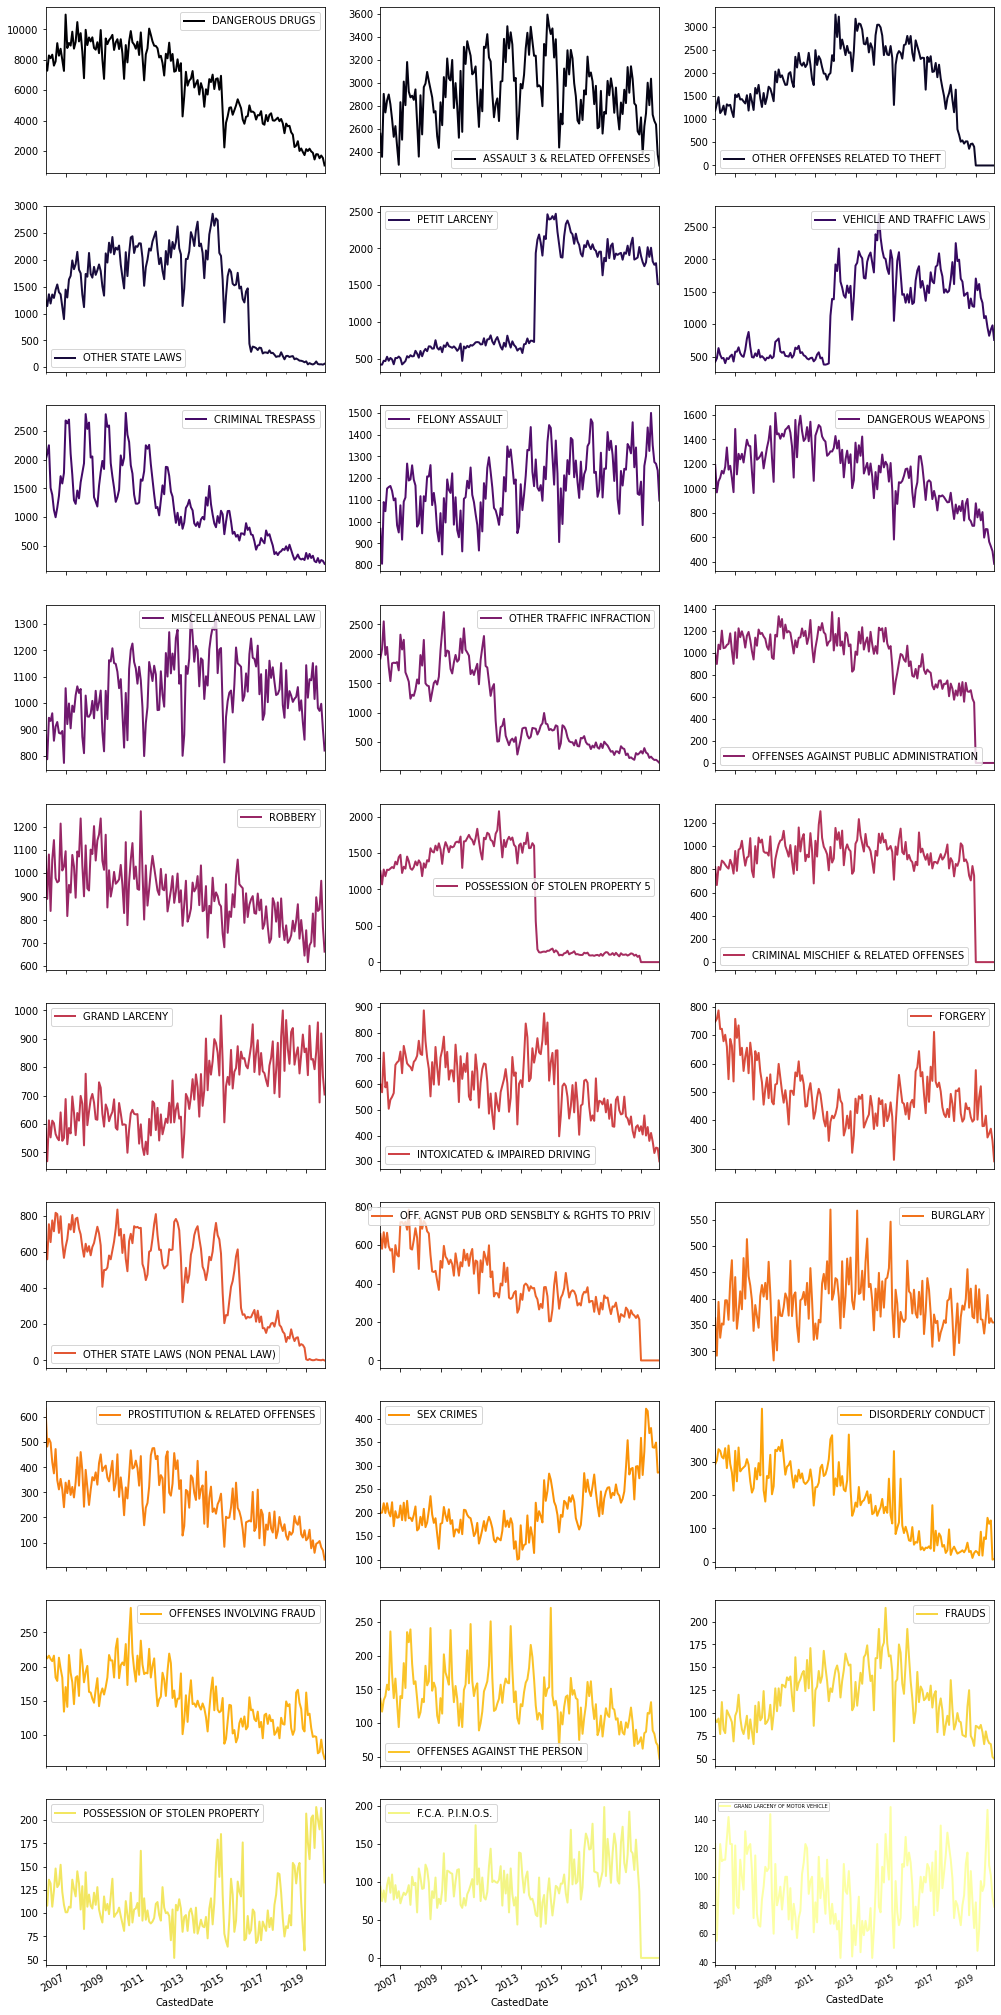

In [23]:
#Generate Plot
day_vs_crimetype_pivot.resample('M').sum().plot(figsize=(17,40), linewidth=2, cmap='inferno', subplots=True, layout=(-1, 3))
plt.legend(prop={'size':5})
plt.tick_params(labelsize=8)

In [0]:
#Helper Functions
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
#Plots hmap for scaled data with an additional clustering step for better visuals.
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort()
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    return df_marginal_scaled
    
#Normalizes Data with min-max norm
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


Small Multiples of Crime Types vs Day of Month

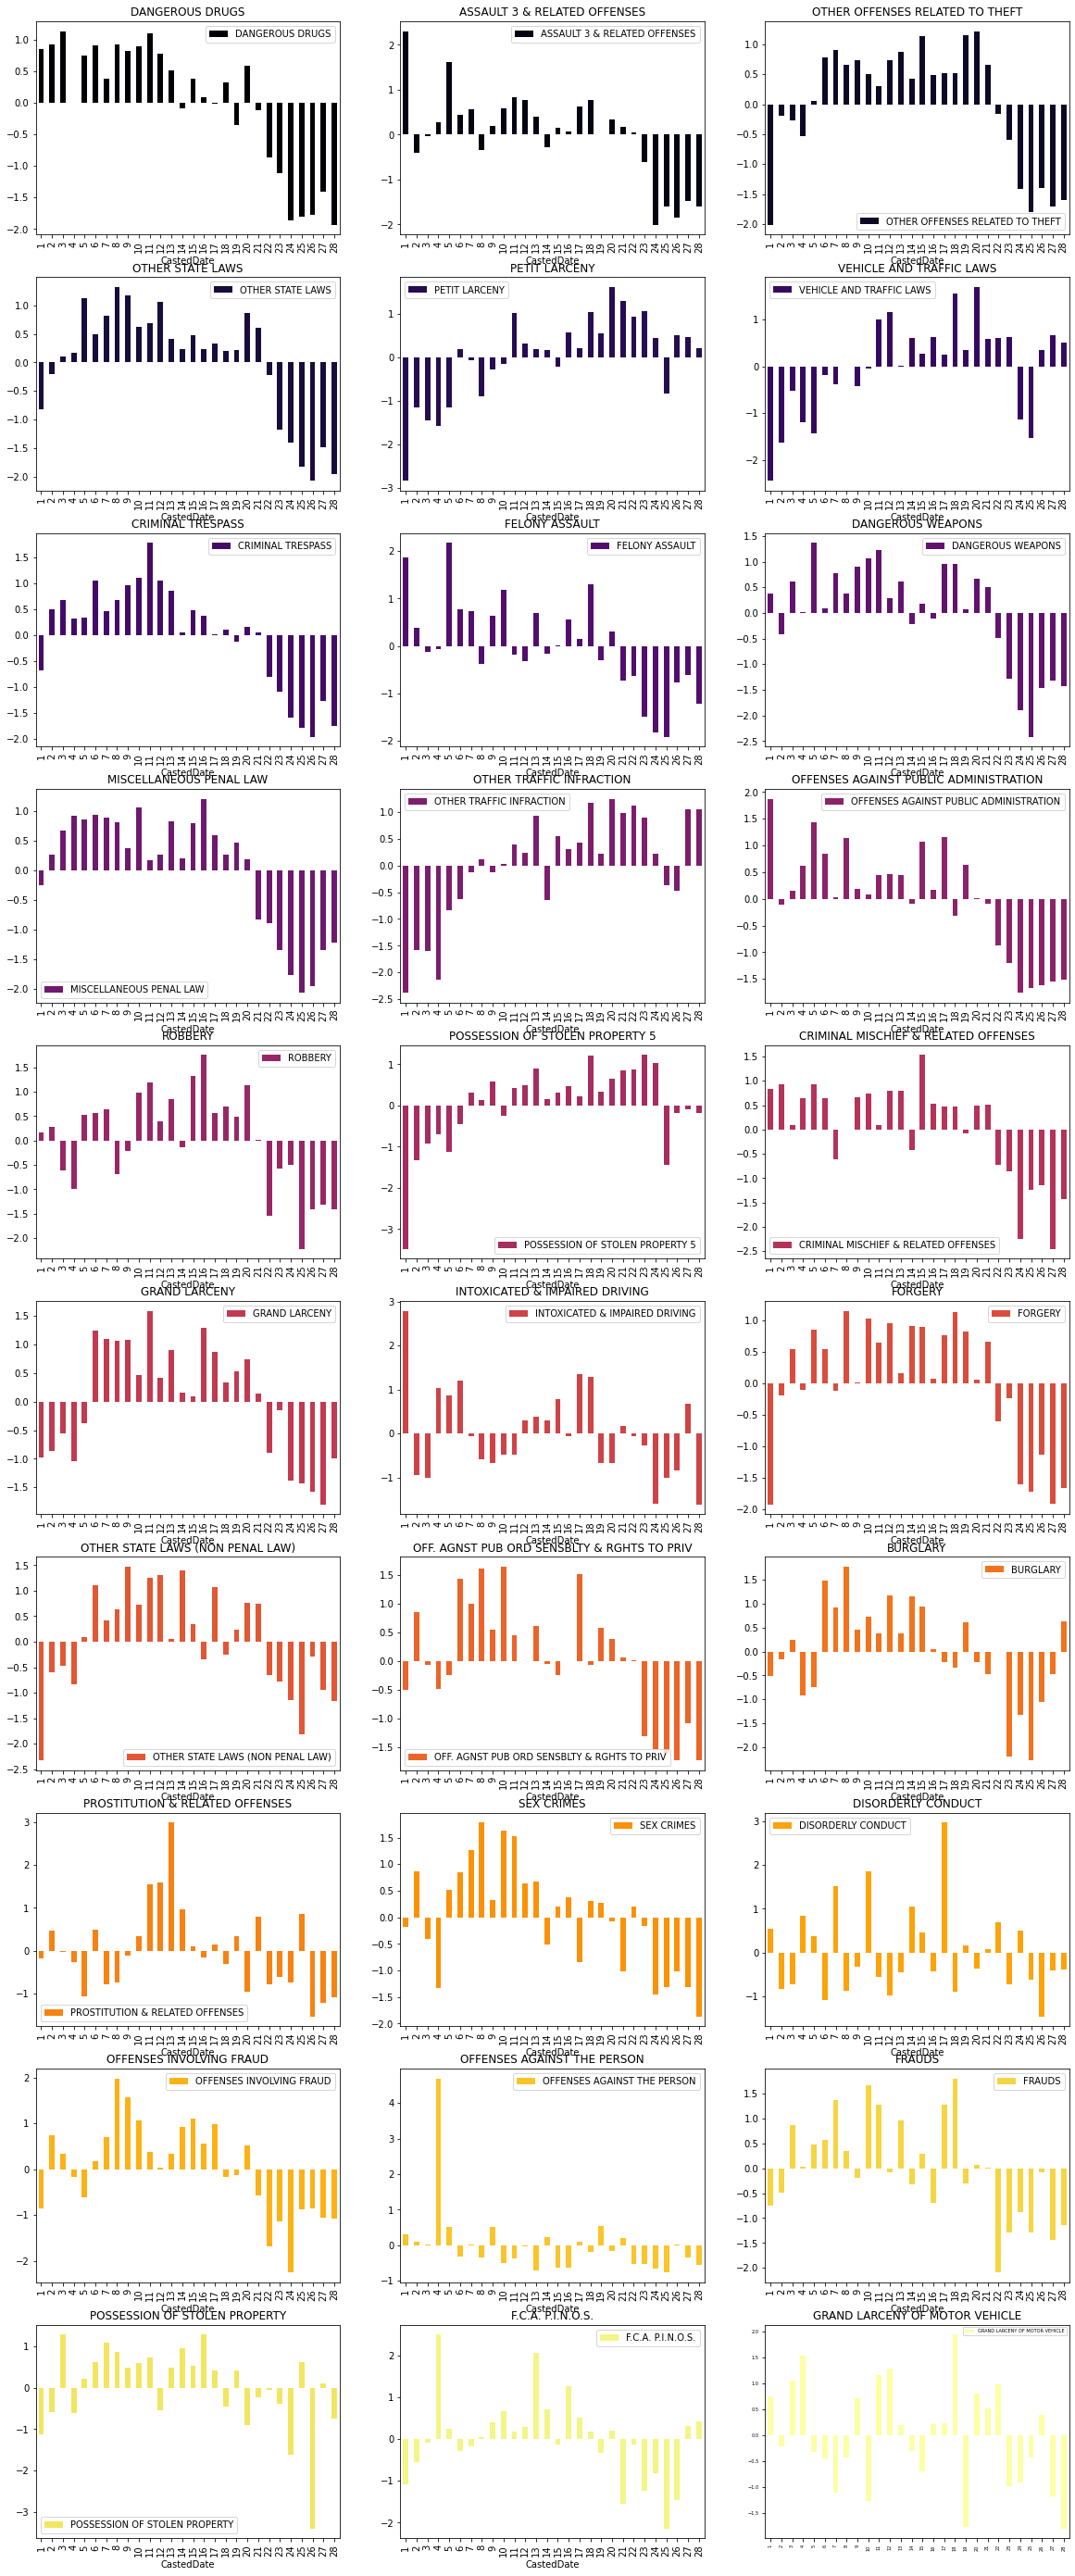

In [26]:
#Plotting only for first 28 days since 29th, 30th and 31st is not present in Feb
scale_df(day_vs_crimetype_pivot.groupby(day_vs_crimetype_pivot.index.day).sum().iloc[:28]).plot(kind='bar', figsize=(20,50), linewidth=2, cmap='inferno', subplots=True, layout=(-1, 3), sharex=False, sharey=False)
plt.legend(prop={'size':5})
plt.xlabel('')
plt.tick_params(labelsize=5)

Small Multiples of Crime Types vs Month of Year

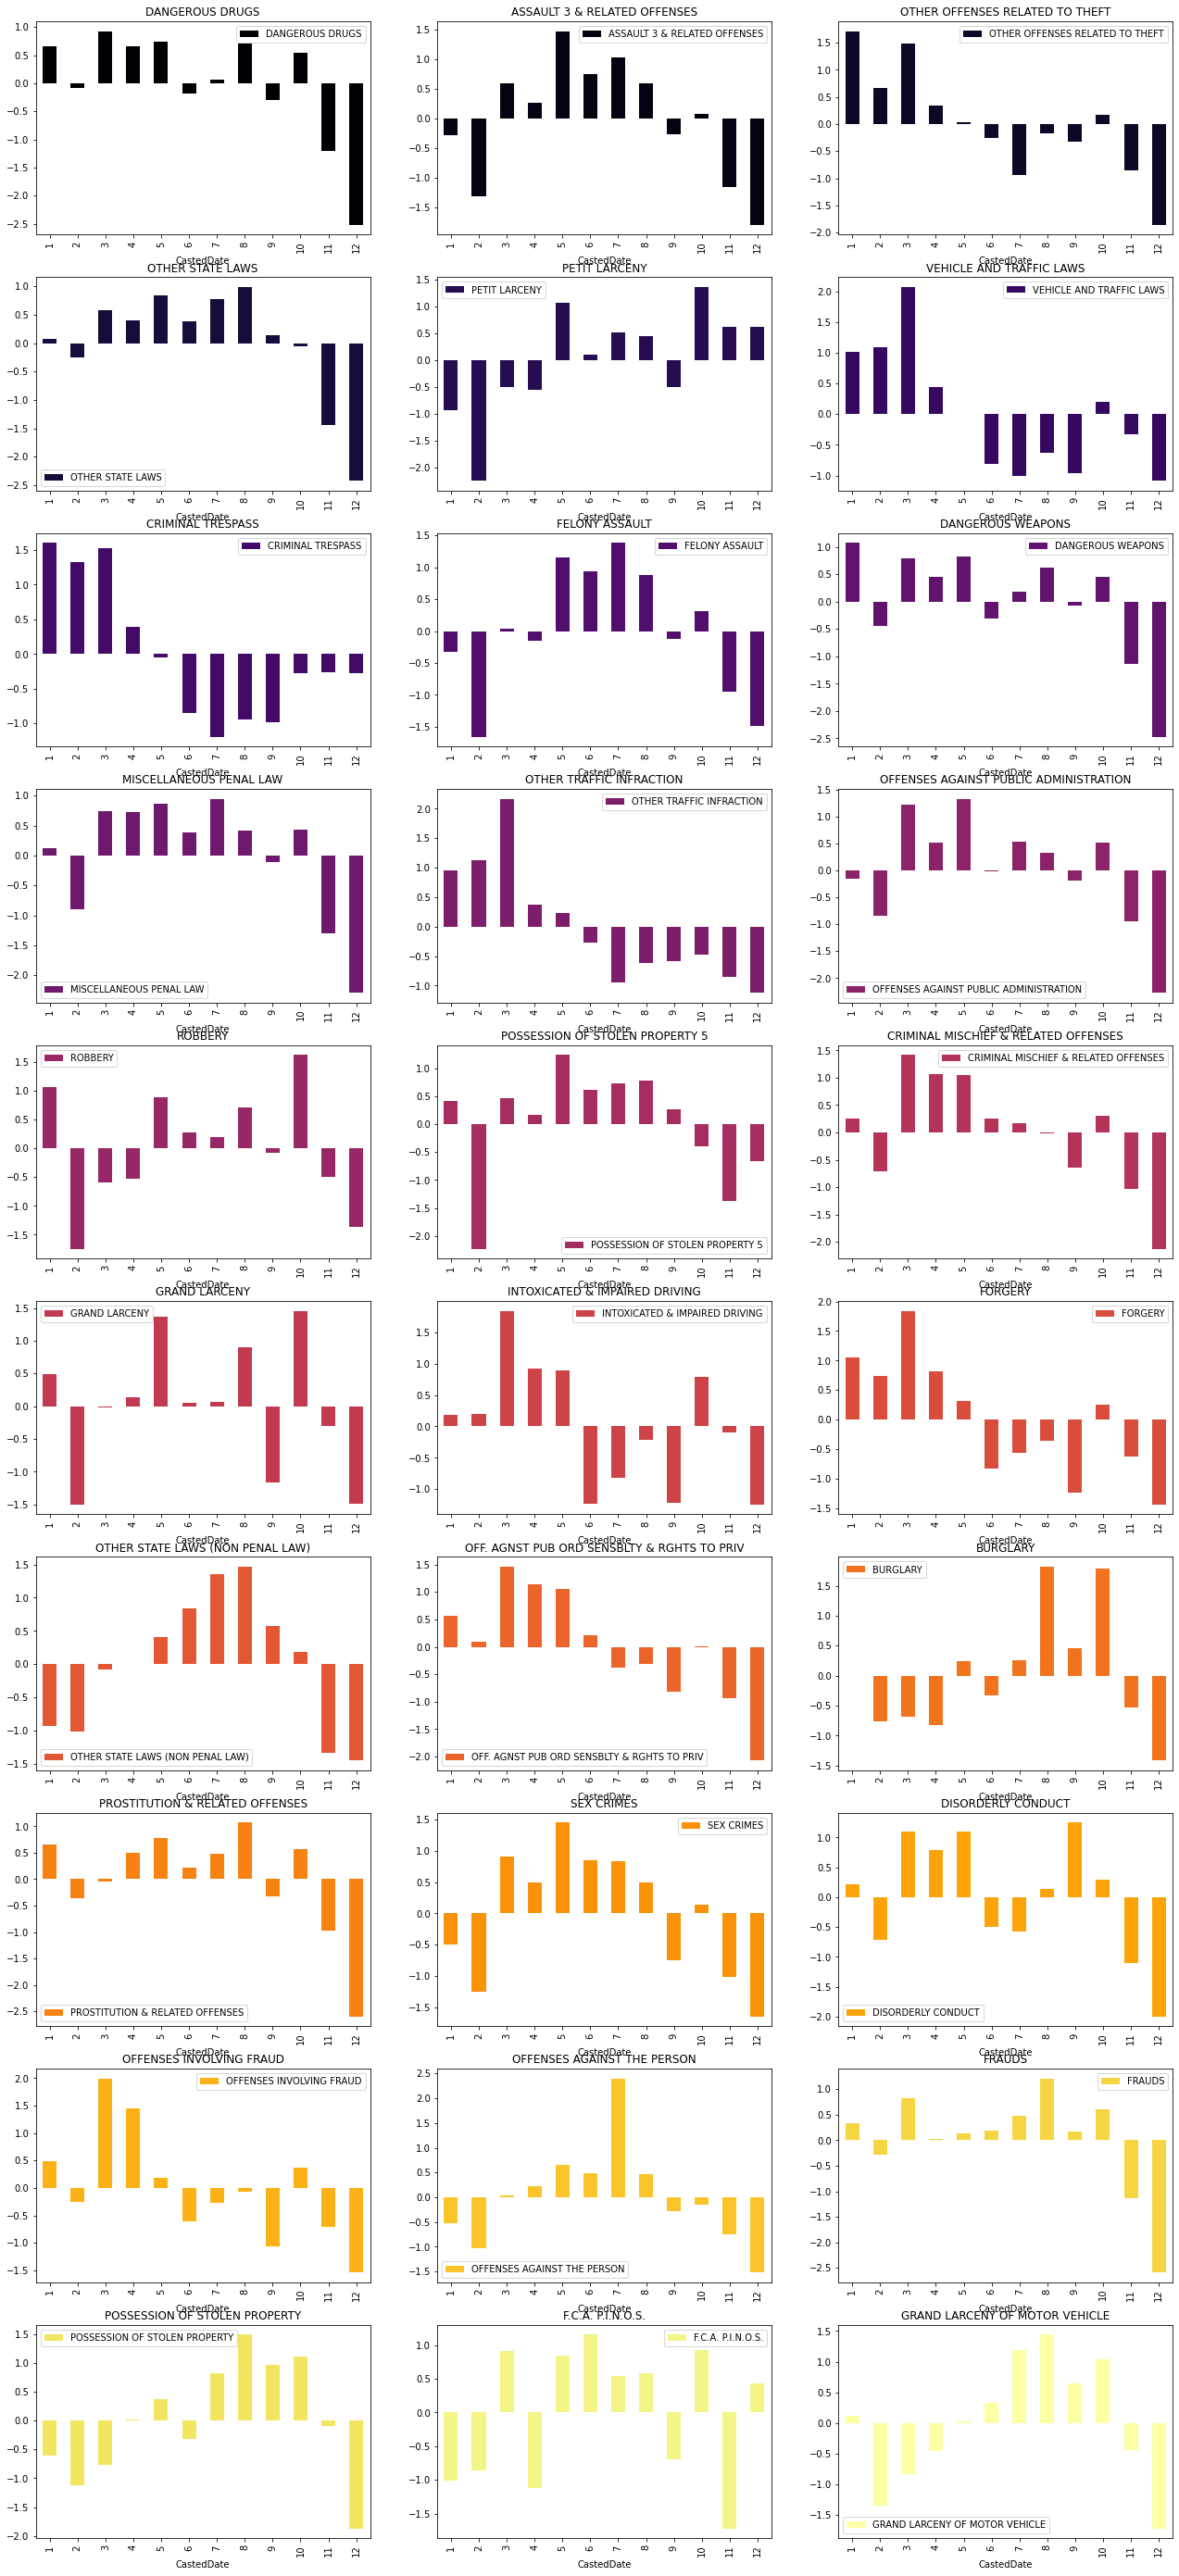

In [29]:
scale_df(day_vs_crimetype_pivot.groupby(day_vs_crimetype_pivot.index.month).sum()) \
.plot(kind='bar', figsize=(22,50), linewidth=2, cmap='inferno', subplots=True, layout=(-1, 3), sharex=False, sharey=False)
plt.show()